In [1]:
import zCurve as z
import csv
import cv2
import os
import numpy as np
import pandas as pd
import glob
import json 
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [2]:
def calculateMortonFromList_with_zCurve(values):
    # Cap floating point numbers to one decimal place and convert to integers
    int_values = [int(round(value, 1) * 10) for value in values]
    value = z.interlace(*int_values, dims=len(int_values))
    return value 

In [3]:
#seq_path = '../datasets/smirk/child/9jJxC2pmKULPI8arYKQ5O/'
seq_path = '../datasets/smirk/child/gk1NNTxMPjb7jbNLEXnAc'
config_path = '../config.json'

In [4]:
with open(config_path, 'r') as _f:
    config = json.load(_f)

In [5]:
config

{'General': {'device': 'cuda:0', 'epochs': 400, 'batch_size': 24},
 'mlnet_input_size': [640, 480],
 'mlnet_model_path': './model_paths/mlnet/mlnet_25.pth',
 'mlnet_pred_saving_path': '',
 'attention_grid': {'width': 53,
  'height': 120,
  'grid_left_top_coord': [[128, 216],
   [181, 216],
   [234, 216],
   [352, 216],
   [405, 216],
   [458, 216]],
  'threshold': 0.2},
 'Dataset': {'name': 'smirk',
  'transforms': {'image_mean': [0.485, 0.456, 0.406],
   'image_std': [0.229, 0.224, 0.225]}},
 'Morton_Detect': {'cell_ranges': {'0': [2.7e-07, 5.5e-07],
   '1': [6.5e-07, 1e-06],
   '2': [1.44e-06, 1.84e-06],
   '3': [3.1e-06, 3.5e-06],
   '4': [6.3e-06, 6.8e-06],
   '5': [1.28e-05, 1.34e-05]}}}

In [6]:
#sorted(os.listdir(seq_path))

In [7]:
rgb_path = os.path.join(seq_path,'cam000200.png')
rgb_path

'../datasets/smirk/child/gk1NNTxMPjb7jbNLEXnAc/cam000200.png'

In [44]:
yolo = YOLO("yolo11x.pt")  # load an official model
# Predict with the model
#results = yolo([rgb_path, os.path.join(seq_path,'cam000202.png')])
results = yolo.predict(rgb_path, verbose=False)

In [16]:
for result in results:
    # result.show()
    result = result.boxes.cpu().numpy()
    if result.data.size > 0:
        xyxy = result.xyxy.astype(np.int64)
        xywh = result.xywh.astype(np.int64)
        yolo_start_point = [xyxy[0][0], xyxy[0][1]]
        yolo_end_point = [xyxy[0][2], xyxy[0][3]]
    else:
        yolo_start_point = None
        yolo_end_point = None

In [17]:
print(result)

ultralytics.engine.results.Boxes object with attributes:

cls: array([], dtype=float32)
conf: array([], dtype=float32)
data: array([], shape=(0, 6), dtype=float32)
id: None
is_track: False
orig_shape: (480, 752)
shape: (0, 6)
xywh: array([], shape=(0, 4), dtype=float32)
xywhn: array([], shape=(0, 4), dtype=float32)
xyxy: array([], shape=(0, 4), dtype=float32)
xyxyn: array([], shape=(0, 4), dtype=float32)


In [18]:
yolo_end_point

In [19]:
rgb_cv2 = cv2.imread(rgb_path)

In [20]:
attention_cells_start_cord = config['attention_grid']['grid_left_top_coord'] # top-left point of bbox
attention_cells_start_cord = np.array(attention_cells_start_cord)
for i in attention_cells_start_cord:
    print(i)
#attention_cells_start_cord[0] + np.array([1,1])
#print(sum(attention_cells_start_cord[0], [1,1]))

[128 216]
[181 216]
[234 216]
[352 216]
[405 216]
[458 216]


In [21]:
attention_cell_width = config['attention_grid']['width']
attention_cell_height = config['attention_grid']['height']

In [22]:
attention_cells_end_cord = [start_piont + np.array([attention_cell_width, attention_cell_height]) for start_piont in attention_cells_start_cord]
attention_cells_end_cord

[array([181, 336]),
 array([234, 336]),
 array([287, 336]),
 array([405, 336]),
 array([458, 336]),
 array([511, 336])]

In [23]:
for i in range(len(attention_cells_start_cord)):
    rgb_cell_draw = cv2.rectangle(rgb_cv2, attention_cells_start_cord[i], attention_cells_end_cord[i], (0,255,0), 1)

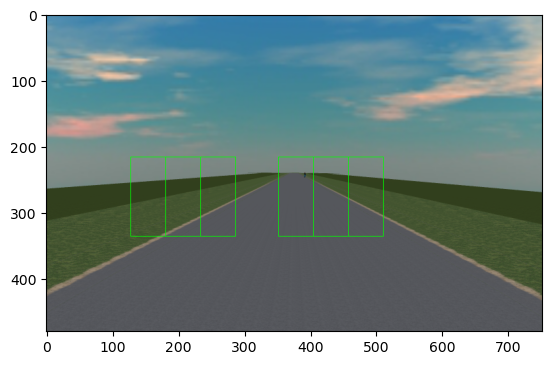

In [24]:
plt.imshow(cv2.cvtColor(rgb_cell_draw, cv2.COLOR_BGR2RGB))

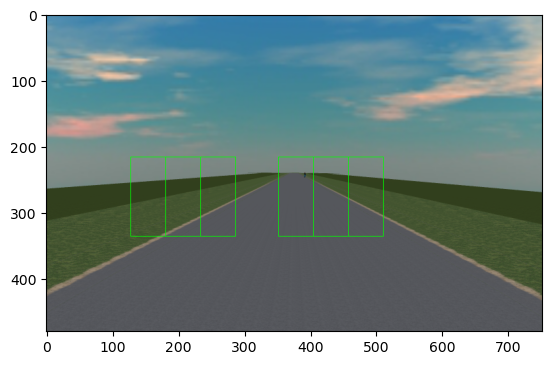

In [25]:
rgb_cell_yolo_draw = cv2.rectangle(rgb_cell_draw, yolo_start_point, yolo_end_point, (0,0,255), 1)
plt.imshow(cv2.cvtColor(rgb_cell_yolo_draw, cv2.COLOR_BGR2RGB))

In [26]:
def overlap(cell_cord, yolo_cord): # [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    x_left = max(cell_cord[0], yolo_cord[0])
    x_right = min(cell_cord[2], yolo_cord[2])
    y_top = max(cell_cord[1], yolo_cord[1])
    y_bottom = min(cell_cord[3], yolo_cord[3])

    if x_right < x_left or y_bottom < y_top:
        return 0, 0, 0, 0, 0
    overlap_area = (x_right - x_left) * (y_bottom - y_top)
    return overlap_area, x_left, y_top, x_right, y_bottom

In [34]:
print(yolo_start_point)
print(yolo_end_point)
if yolo_start_point is not None and yolo_end_point is not None:
    yolo_cord = np.concatenate([yolo_start_point, yolo_end_point])
    print(yolo_cord)
else: 
    yolo_cord = [0,0,0,0]

None
None


In [35]:
print(attention_cells_start_cord)
print(attention_cells_end_cord)

[[128 216]
 [181 216]
 [234 216]
 [352 216]
 [405 216]
 [458 216]]
[array([181, 336]), array([234, 336]), array([287, 336]), array([405, 336]), array([458, 336]), array([511, 336])]


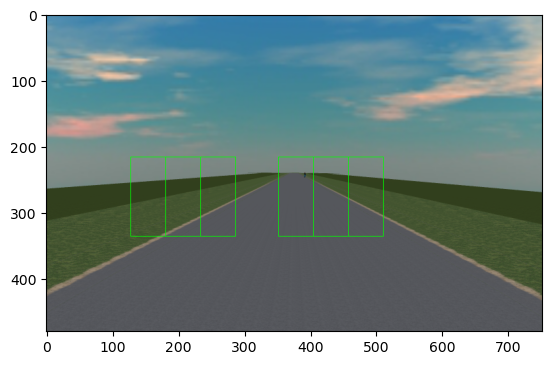

In [36]:
for i in range(len(attention_cells_start_cord)):
    cell_cord = np.concatenate([attention_cells_start_cord[i], attention_cells_end_cord[i]], axis=0)
    
    overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_cord, yolo_cord)
    color = list(np.random.random(size=3) * 256)
    rgb_overlap = cv2.rectangle(rgb_cell_yolo_draw, [x_left, y_top], [x_right, y_bottom], color, 2)
plt.imshow(cv2.cvtColor(rgb_overlap, cv2.COLOR_BGR2RGB))

# Propotion

In [37]:
input_zcurve = np.zeros(6)
for i in range(len(attention_cells_start_cord)):
    cell_cord = np.concatenate([attention_cells_start_cord[i], attention_cells_end_cord[i]], axis=0)
    overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_cord, yolo_cord)

    yolo_bbox_area = (yolo_cord[2] - yolo_cord[0]) * (yolo_cord[3] - yolo_cord[1])
    
    if overlap_area > 0:
        input_zcurve[i] = overlap_area / yolo_bbox_area
    
    print(overlap_area, x_left, y_top, x_right, y_bottom)
print(input_zcurve)

0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
[          0           0           0           0           0           0]


In [38]:
morton_rgb = calculateMortonFromList_with_zCurve(input_zcurve)
morton_rgb

0

### Combine everything to process all images in a sequence. 

In [45]:
morton_codes = []
for anno_frame in sorted(glob.glob(os.path.join(seq_path, '*.labels.png'))):
    rgb_frame = anno_frame.replace('.labels.png', '.png')
    yolo_start_point = [0, 0]
    yolo_end_point = [0, 0]
    results = yolo.predict(rgb_frame, verbose=False)
    for result in results:
        # result.show()
        result = result.boxes.cpu().numpy()
        if result.data.size > 0: # makde sure there is detection from yolo
            xyxy = result.xyxy.astype(np.int64)
            xywh = result.xywh.astype(np.int64)
            yolo_start_point = [xyxy[0][0], xyxy[0][1]]
            yolo_end_point = [xyxy[0][2], xyxy[0][3]]
    
    rgb_cv2 = cv2.imread(rgb_frame)
    for i in range(len(attention_cells_start_cord)):
        rgb_cell_draw = cv2.rectangle(rgb_cv2, attention_cells_start_cord[i], attention_cells_end_cord[i], (0,255,0), 1)    
    rgb_cell_yolo_draw = cv2.rectangle(rgb_cell_draw, yolo_start_point, yolo_end_point, (0,0,255), 1)
    
    result_path = rgb_frame.replace('datasets/smirk', 'outputs/smirk_yolo')
    if not os.path.exists(os.path.dirname(result_path)):
        os.makedirs(os.path.dirname(result_path))
    cv2.imwrite(result_path, rgb_cell_yolo_draw)

    yolo_cord = np.concatenate([yolo_start_point, yolo_end_point])

    input_zcurve = np.zeros(6)
    for i in range(len(attention_cells_start_cord)):
        cell_cord = np.concatenate([attention_cells_start_cord[i], attention_cells_end_cord[i]], axis=0)
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_cord, yolo_cord)
        yolo_bbox_area = (yolo_cord[2] - yolo_cord[0]) * (yolo_cord[3] - yolo_cord[1])
         
        color = list(np.random.random(size=3) * 256)
        rgb_overlap = cv2.rectangle(rgb_cell_yolo_draw, [x_left, y_top], [x_right, y_bottom], color, 2)
        if overlap_area > 0:
            input_zcurve[i] = overlap_area / yolo_bbox_area
    
    overlap_path = rgb_frame.replace('datasets/smirk', 'outputs/smirk_overlap')
    if not os.path.exists(os.path.dirname(overlap_path)):
        os.makedirs(os.path.dirname(overlap_path))
    cv2.imwrite(overlap_path, rgb_overlap)

    morton_rgb = calculateMortonFromList_with_zCurve(input_zcurve)
    morton_codes.append({'frame': rgb_frame, 'morton': morton_rgb})

morton_codes = pd.DataFrame(morton_codes, columns=['frame', 'morton'])
morton_codes.to_csv('../outputs/morton_codes_yolo_proportion.csv', sep=';', index=False)

### Read the saved csv and plot

In [46]:
morton_codes_yolo_proportion = pd.read_csv('../outputs/morton_codes_yolo_proportion.csv', sep=';')
morton_codes_yolo_proportion = morton_codes_yolo_proportion.to_numpy()

In [54]:
mortons_seq = []
for i in range(len(morton_codes_yolo_proportion)):
    frame, morton = morton_codes_yolo_proportion[i]
    mortons_seq.append(int(morton)/100000)
print(mortons_seq)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00512, 0.00512, 0.00512, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.97664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.97664, 0.0, 20.97664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.97664, 20.97664, 20.97664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

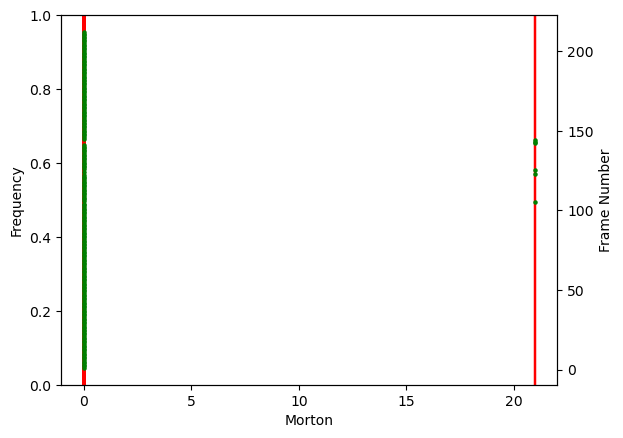

In [55]:
_, ax1 = plt.subplots()
ax1.set_xlabel("Morton")
ax1.set_ylabel("Frequency")
ax1.set_ylim((0, 1))
ax1.eventplot(mortons_seq, orientation='horizontal', colors="red",lineoffsets=0.5)

ax2 = ax1.twinx()
for frame_id in range(len(mortons_seq)):
    x=mortons_seq[frame_id]
    y=frame_id+1
    ax2.scatter(x, y, s=5, color='green')
    ax2.set_ylabel("Frame Number")

# Area

In [50]:
morton_codes = []
for anno_frame in sorted(glob.glob(os.path.join(seq_path, '*.labels.png'))):
    rgb_frame = anno_frame.replace('.labels.png', '.png')
    yolo_start_point = [0, 0]
    yolo_end_point = [0, 0]
    results = yolo.predict(rgb_frame, verbose=False)
    for result in results:
        # result.show()
        result = result.boxes.cpu().numpy()
        if result.data.size > 0: # makde sure there is detection from yolo
            xyxy = result.xyxy.astype(np.int64)
            xywh = result.xywh.astype(np.int64)
            yolo_start_point = [xyxy[0][0], xyxy[0][1]]
            yolo_end_point = [xyxy[0][2], xyxy[0][3]]
    
    rgb_cv2 = cv2.imread(rgb_frame)
    for i in range(len(attention_cells_start_cord)):
        rgb_cell_draw = cv2.rectangle(rgb_cv2, attention_cells_start_cord[i], attention_cells_end_cord[i], (0,255,0), 1)    
    rgb_cell_yolo_draw = cv2.rectangle(rgb_cell_draw, yolo_start_point, yolo_end_point, (0,0,255), 1)
    
    # result_path = rgb_frame.replace('datasets/smirk', 'outputs/smirk_yolo')
    # if not os.path.exists(os.path.dirname(result_path)):
    #     os.makedirs(os.path.dirname(result_path))
    # cv2.imwrite(result_path, rgb_cell_yolo_draw)

    yolo_cord = np.concatenate([yolo_start_point, yolo_end_point])

    input_zcurve = np.zeros(6)
    for i in range(len(attention_cells_start_cord)):
        cell_cord = np.concatenate([attention_cells_start_cord[i], attention_cells_end_cord[i]], axis=0)
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_cord, yolo_cord)
        yolo_bbox_area = (yolo_cord[2] - yolo_cord[0]) * (yolo_cord[3] - yolo_cord[1])
         
        color = list(np.random.random(size=3) * 256)
        rgb_overlap = cv2.rectangle(rgb_cell_yolo_draw, [x_left, y_top], [x_right, y_bottom], color, 2)
        if overlap_area > 0:
            input_zcurve[i] = overlap_area     
    # overlap_path = rgb_frame.replace('datasets/smirk', 'outputs/smirk_overlap')
    # if not os.path.exists(os.path.dirname(overlap_path)):
    #     os.makedirs(os.path.dirname(overlap_path))
    # cv2.imwrite(overlap_path, rgb_overlap)

    morton_rgb = calculateMortonFromList_with_zCurve(input_zcurve)
    morton_codes.append({'frame': rgb_frame, 'morton': morton_rgb})

morton_codes = pd.DataFrame(morton_codes, columns=['frame', 'morton'])
morton_codes.to_csv('../outputs/morton_codes_yolo_area.csv', sep=';', index=False)

### Read the csv jsut saved and plot

In [51]:
morton_codes_yolo_area = pd.read_csv('../outputs/morton_codes_yolo_area.csv', sep=';')
morton_codes_yolo_area = morton_codes_yolo_area.to_numpy()

In [52]:
mortons_seq = []
for i in range(len(morton_codes_yolo_area)):
    frame, morton = morton_codes_yolo_area[i]
    mortons_seq.append(int(morton) / 1000000000000000000000000000)
print(mortons_seq)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.58345781248e-16, 5.4989212928e-16, 5.58347878912e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.286984319991808e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.287542665773056e-12, 0.0, 2.286984319991808e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.25235816153088e-12, 2.287542665773056e-12, 2.28753394158848e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

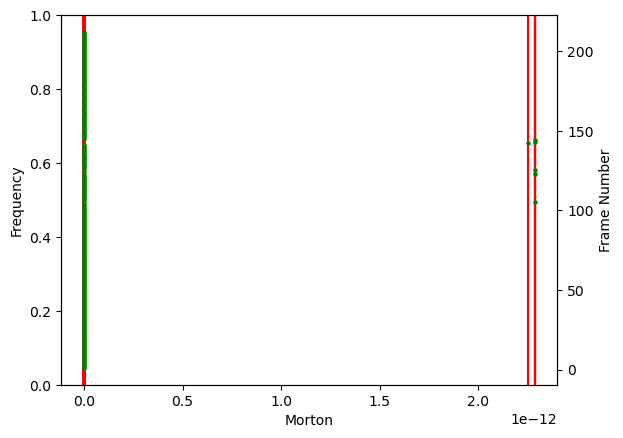

In [53]:
_, ax1 = plt.subplots()
ax1.set_xlabel("Morton")
ax1.set_ylabel("Frequency")
ax1.set_ylim((0, 1))
ax1.eventplot(mortons_seq, orientation='horizontal', colors="red",lineoffsets=0.5)

ax2 = ax1.twinx()
for frame_id in range(len(mortons_seq)):
    x=mortons_seq[frame_id]
    y=frame_id+1
    ax2.scatter(x, y, s=5, color='green')
    ax2.set_ylabel("Frame Number")